In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
from scipy import signal
import glob
from astropy.table import Table
import os
homedir = os.path.expanduser('~')
from Starfish.spectrum import Spectrum
from Starfish.models import SpectrumModel
import emcee
import scipy.stats as st
import arviz as az
import corner

In [2]:
filelist = sorted(glob.glob(f'{homedir}/uoedrive/data/IGRINS_W1049B/SDCK*_1f.spec.fits'))
fluxes = []
wls = []

for filename in filelist:
    wlname = filename.split('_1f')[0]+'.wave.fits'

    flux = fits.getdata(filename)
    wl = fits.getdata(wlname)
    hdr = fits.getheader(filename)
    # trim first and last 100 columns
    flux = flux[:, 100:1948]
    wl = wl[:, 100:1948]
    
    fluxes.append(flux)
    wls.append(wl)
dims = np.array(fluxes).shape
fluxes = np.array(fluxes)
wls = np.array(wls)

obs0 = np.median(fluxes[:, 1:, :], axis=0)*dims[0]  # make mean spectrum
eobs0 = np.median(fluxes[:, 1:, :], axis=0)*np.sqrt(dims[0])  # make mean noise spectrum (assuming just photon noise)
fobs0 = np.vstack([signal.medfilt(obs0[jj], 3) for jj in range(dims[1]-1)])  # smooth spectrum
# fix wavelength array to have same shape
wls = wls[:, 1:24, :] 

In [3]:
obs=22
order=4
target="W1049B"
band="K"

resultdir = f"run_IGRINS_{target}_{band}_order{order}_test"
if not os.path.exists(resultdir):
    os.mkdir(resultdir)

wl_order = wls[obs, order, :] *10000
flux_order = fobs0[order]
data = Spectrum(wl_order, flux_order, sigmas=None, masks=None, name="Spectrum")

### Setting up the model
Some of these parameters are based on guesses or pre-existing knowledge. In particular, if you want to fit `log_scale`, you should spend some time tuning it by eye, first. We also want our `global_cov:log_amp` to be reasonable, so pay attention to the $\sigma$-contours in the residuals plots, too.

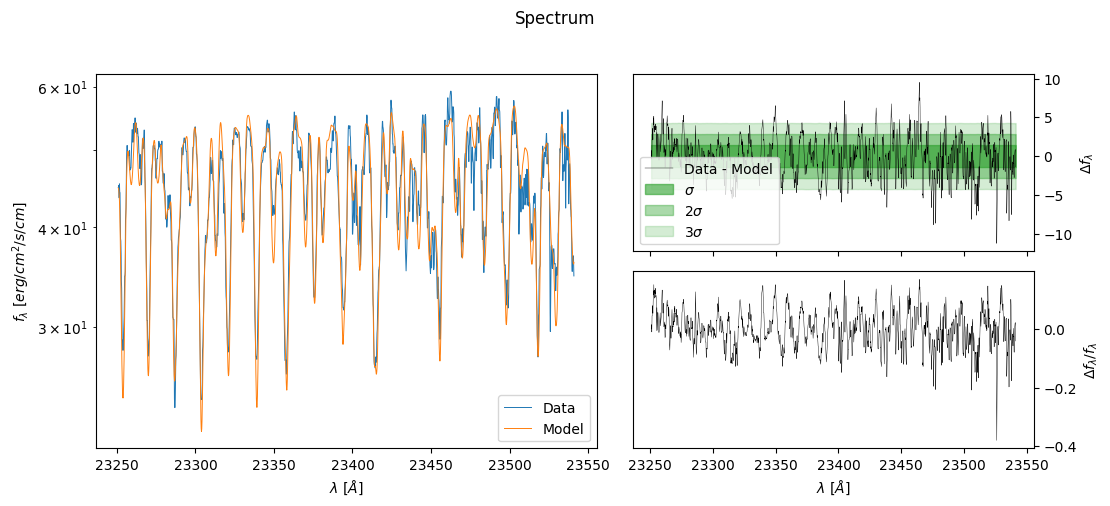

In [4]:
model = SpectrumModel(
    emulator="BTSettl_K_emu.hdf5",
    data=data,
    grid_params=[1500, 5.0],
    vsini=25,
    vz=105,
    cheb=[0, 0],
    global_cov=dict(log_amp=0, log_ls=1),
)

model.plot()
plt.savefig(f"{resultdir}/plot_model.png")
model.save(f"{resultdir}/model_created.toml")

#### MCMC Sampling

Here we specify some priors using `scipy.stats` classes. If you have a custom distribution you want to use, create a class and make sure it has a `logpdf` member function.

In [5]:
string = """priors = {
    "T": st.uniform(1200,750),
    "logg": st.uniform(2.5,3),
    "vsini": st.uniform(0, 500),
    "vz": st.uniform(10, 100),
    "cheb:1": st.uniform(-3, 6),
    "cheb:2": st.uniform(-3, 6),
    "global_cov:log_amp": st.norm(0, 5),
    "global_cov:log_ls": st.uniform(0, 10),
}"""
exec(string)
with open(f"{resultdir}/priors.txt", "w") as f:
    f.write(string)
print(model.log_likelihood(priors))
print(string)

-2012.537669706
priors = {
    "T": st.uniform(1200,750),
    "logg": st.uniform(2.5,3),
    "vsini": st.uniform(0, 500),
    "vz": st.uniform(10, 100),
    "cheb:1": st.uniform(-3, 6),
    "cheb:2": st.uniform(-3, 6),
    "global_cov:log_amp": st.norm(0, 5),
    "global_cov:log_ls": st.uniform(0, 10),
}


In [6]:
#model.load("example_MAP_1.toml")
model.freeze("logg")
model.labels  # These are the fittable parameters

('vsini',
 'vz',
 'global_cov:log_amp',
 'global_cov:log_ls',
 'cheb:1',
 'cheb:2',
 'T')

Numerical Optimization

In [8]:
%time model.train(priors, options={"maxiter": 100})

CPU times: user 14min 38s, sys: 43min 20s, total: 57min 59s
Wall time: 1min 2s


 final_simplex: (array([[2.73356473e+01, 1.03942574e+02, 3.18454394e-04, 5.20859321e-01,
        8.41384979e-04, 5.16508600e-04, 1.51420423e+03, 5.02037394e+00],
       [2.71558641e+01, 1.03854627e+02, 3.16837821e-04, 5.28642193e-01,
        8.45991913e-04, 5.40786380e-04, 1.51382049e+03, 5.01080665e+00],
       [2.71332784e+01, 1.03861176e+02, 2.90657798e-04, 5.07535138e-01,
        9.21721885e-04, 5.57196438e-04, 1.51507416e+03, 5.00881806e+00],
       [2.71870810e+01, 1.04043577e+02, 3.28397080e-04, 5.44635934e-01,
        7.85212525e-04, 4.66597276e-04, 1.51373584e+03, 5.01687686e+00],
       [2.72742813e+01, 1.03854972e+02, 3.07580128e-04, 5.36172157e-01,
        8.13299745e-04, 4.92010129e-04, 1.51592240e+03, 5.03831510e+00],
       [2.71317375e+01, 1.04007909e+02, 3.08919193e-04, 5.01594338e-01,
        9.44962778e-04, 5.49795958e-04, 1.51534172e+03, 5.00470197e+00],
       [2.70477666e+01, 1.04087965e+02, 3.24395806e-04, 5.50525585e-01,
        7.65479294e-04, 5.48620554e-04, 1

SpectrumModel
-------------
Data: Spectrum
Emulator: BTSettl_K_emu
Log Likelihood: -1814.2916662494144

Parameters
  vsini: 27.155864134096696
  vz: 103.85462686941044
  global_cov:
    log_amp: 0.0003168378212329002
    log_ls: 0.5286421925137748
  cheb: [0.0008459919131610674, 0.0005407863796202566]
  T: 1513.820492344687
  logg: 5.01080664763769
  log_scale: 3.945139478671072 (fit)

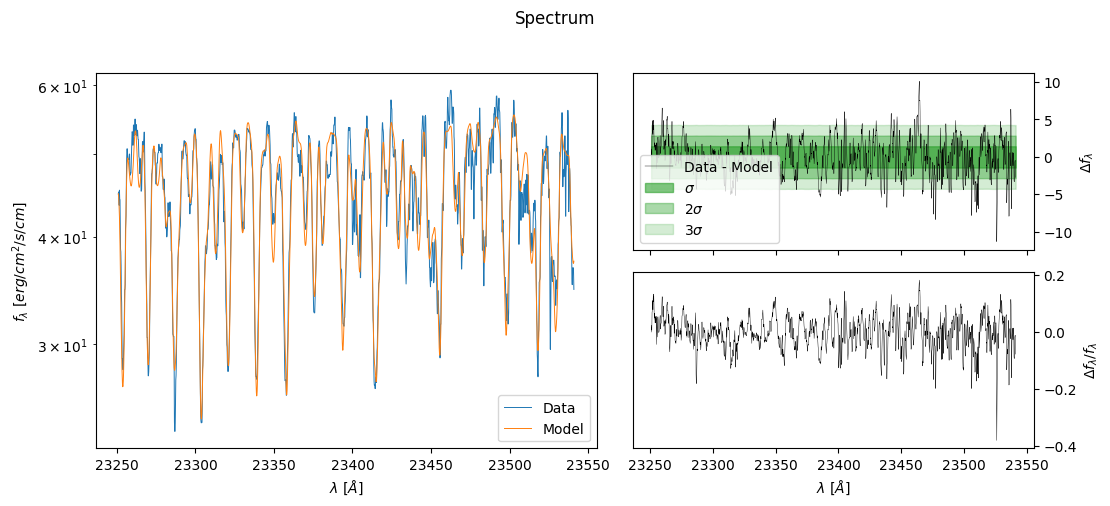

In [9]:
model.plot()
#model.freeze("global_cov")
model

In [13]:
# Set our walkers and dimensionality
nwalkers = 16
ndim = len(model.labels)

# Initialize gaussian ball for starting point of walkers
scales = dict([(label, 1) for label in model.labels])
print("scales:", scales)

ball = np.random.randn(nwalkers, ndim)
print(ball[:,0])

for i, key in enumerate(model.labels):
    ball[:, i] *= model[key]/10 # scale the sigma by 1/10 of param value
    ball[:, i] += model[key]
print(ball[:,6])
# our objective to maximize
def log_prob(P, priors):
    model.set_param_vector(P)
    return model.log_likelihood(priors)

# Set up our backend and sampler
backend = emcee.backends.HDFBackend("example_chain.hdf5")
backend.reset(nwalkers, ndim)
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_prob, args=(priors,), backend=backend
)

scales: {'vsini': 1, 'vz': 1, 'global_cov:log_amp': 1, 'global_cov:log_ls': 1, 'cheb:1': 1, 'cheb:2': 1, 'T': 1, 'logg': 1}
[ 0.79214883  1.24164967 -1.41819434  1.16871739 -0.56734491  0.26379897
 -0.84223873 -0.47206728 -0.03847683 -1.23976798  0.2282914   0.39550156
  0.27477271  0.3596737  -1.44926626  1.51927145]
[1953.71659288 1386.19963558 1588.97873482 1532.08000667 1445.61757074
 1587.76468708 1615.34208801 1819.44144514 1629.75267774 1398.41517869
 1502.89514901 2055.81543442 1582.61408403 1506.46865713 1376.4738265
 1475.86292895]


here we start our sampler, check every 10 steps for convergence, with a max burn-in of 1000 samples.

<div class="alert alert-warning">

**Warning:** This process *can* take a long time to finish. In cases with high resolution spectra or fully evaluating each nuisance covariance parameter, we recommend running on a remote machine. A setup I recommend is a remote jupyter server, so you don't have to create any scripts and can keeping working in notebooks.

</div>

In [14]:
max_n = 50
index = 0
autocorr = np.empty(max_n)
old_tau = np.inf
# Now we'll sample for up to max_n steps
for sample in sampler.sample(ball, iterations=max_n, progress=True):
    # Only check convergence every 10 steps
    if sampler.iteration % 10:
        continue
    tau = sampler.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1
    # skip math if it's just going to yell at us
    if np.isnan(tau).any() or (tau == 0).any():
        continue
    # Check convergence
    converged = np.all(tau * 10 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.02)
    if converged:
        print(f"Converged at sample {sampler.iteration}")
        break
    old_tau = tau

  0%|          | 0/50 [00:00<?, ?it/s]/home/xchen/dopplerimg/venv/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 20%|██        | 10/50 [00:36<03:06,  4.66s/it]/home/xchen/dopplerimg/venv/lib/python3.9/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in divide
  acf /= acf[0]
100%|██████████| 50/50 [05:22<00:00,  6.45s/it]


Parallelized version

In [86]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
from multiprocessing import Pool

nwalkers = 10
ndim = len(model.labels)

# Initialize gaussian ball for starting point of walkers
scales = {"T": 1, "vsini": 1, "vz": 1}
ball = np.random.randn(nwalkers, ndim)
for i, key in enumerate(model.labels):
    ball[:, i] *= scales[key]
    ball[:, i] += model[key]

def log_prob(P, priors):
    model.set_param_vector(P)
    return model.log_likelihood(priors)

# Set up our backend and sampler
backend = emcee.backends.HDFBackend("example_chain.hdf5")
backend.reset(nwalkers, ndim)
with Pool() as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_prob, args=(priors,), backend=backend
    )

    max_n = 500

    # We'll track how the average autocorrelation time estimate changes
    index = 0
    autocorr = np.empty(max_n)

    # This will be useful to testing convergence
    old_tau = np.inf

    # Now we'll sample for up to max_n steps
    for sample in sampler.sample(ball, iterations=max_n, progress=True):
        # Only check convergence every 10 steps
        if sampler.iteration % 10:
            continue

        # Compute the autocorrelation time so far
        # Using tol=0 means that we'll always get an estimate even
        # if it isn't trustworthy
        tau = sampler.get_autocorr_time(tol=0)
        autocorr[index] = np.mean(tau)
        index += 1
        # skip math if it's just going to yell at us
        if np.isnan(tau).any() or (tau == 0).any():
            continue
        # Check convergence
        converged = np.all(tau * 10 < sampler.iteration)
        converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
        if converged:
            print(f"Converged at sample {sampler.iteration}")
            break
        old_tau = tau

  0%|          | 1/500 [00:33<4:37:54, 33.42s/it]Traceback (most recent call last):
  File "/home/xchen/dopplerimg/venv/lib/python3.9/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/tmp/ipykernel_3116325/373837380.py", line 17, in log_prob
    return model.log_likelihood(priors)
  File "/home/xchen/dopplerimg/venv/src/astrostarfish/Starfish/models/spectrum_model.py", line 398, in log_likelihood
    flux, cov = self()
  File "/home/xchen/dopplerimg/venv/src/astrostarfish/Starfish/models/spectrum_model.py", line 296, in __call__
    fluxes = resample(wave, fluxes, self.data.wave)
  File "/home/xchen/dopplerimg/venv/src/astrostarfish/Starfish/transforms.py", line 39, in resample
    interpolators = [InterpolatedUnivariateSpline(wave, fl, k=5) for fl in flux]
  File "/home/xchen/dopplerimg/venv/src/astrostarfish/Starfish/transforms.py", line 39, in <listcomp>
    interpolators = [InterpolatedUnivariateSpline(wave, fl, k=5) fo

emcee: Exception while calling your likelihood function:
  params: [  23.88068875  107.39306848 1490.99562051]
  args: ({'T': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f055c18b0d0>, 'vsini': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f055d8638e0>, 'vz': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f055c18bfa0>},)
  kwargs: {}
  exception:


KeyboardInterrupt: 

After our model has converged, let's take a few extra samples to make sure we have clean chains. Remember, we have 50 walkers, so 100 samples ends up becoming 5000 across each chain!

In [15]:
sampler.run_mcmc(backend.get_last_sample(), 100, progress=True, store=True);

100%|██████████| 100/100 [46:00<00:00, 27.60s/it]


#### MCMC Chain Analysis

In [16]:
reader = emcee.backends.HDFBackend("example_chain.hdf5")
full_data = az.from_emcee(reader, var_names=model.labels)

/home/xchen/dopplerimg/venv/lib/python3.9/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  plot_kde : Compute and plot a kernel density estimate.
/home/xchen/dopplerimg/venv/lib/python3.9/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  plot_kde : Compute and plot a kernel density estimate.
/home/xchen/dopplerimg/venv/lib/python3.9/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  plot_kde : Compute and plot a kernel density estimate.
/home/xchen/dopplerimg/venv/lib/python3.9/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  plot_kde : Compute and plot a kernel density estimate.
/home/xchen/dopplerimg/venv/lib/python3.9/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data app

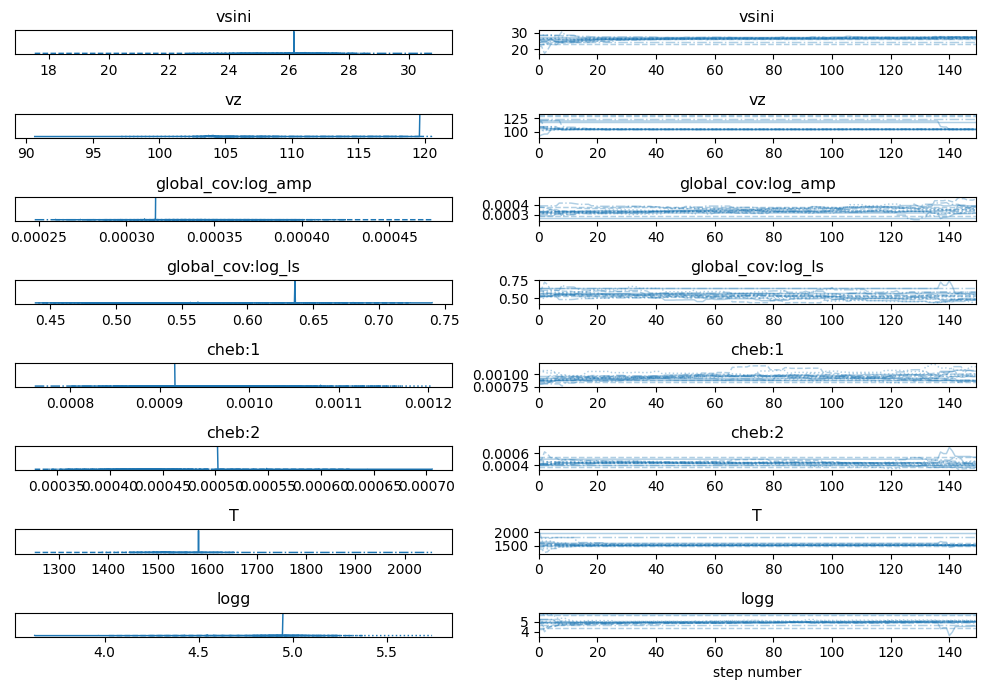

In [17]:
az.plot_trace(full_data, figsize=(10,7));
plt.xlabel("step number")
plt.tight_layout()

After seeing our full traces, let's discard and thin some of the burn-in

In [22]:
min(tau.max(), 50)

nan

In [25]:
tau

array([nan, nan, nan, nan, nan,  1., nan, nan])

In [26]:
tau = reader.get_autocorr_time(tol=0)
try:
    burnin = int(tau.max())
except:
    burnin = 50
#thin = int(0.3 * np.min(tau))
thin=1
burn_samples = reader.get_chain(discard=burnin, thin=thin)
log_prob_samples = reader.get_log_prob(discard=burnin, thin=thin)
log_prior_samples = reader.get_blobs(discard=burnin, thin=thin)

dd = dict(zip(model.labels, burn_samples.T))
burn_data = az.from_dict(dd)

/home/xchen/dopplerimg/venv/lib/python3.9/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in divide
  acf /= acf[0]


/home/xchen/dopplerimg/venv/lib/python3.9/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  plot_kde : Compute and plot a kernel density estimate.
/home/xchen/dopplerimg/venv/lib/python3.9/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  plot_kde : Compute and plot a kernel density estimate.
/home/xchen/dopplerimg/venv/lib/python3.9/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  plot_kde : Compute and plot a kernel density estimate.
/home/xchen/dopplerimg/venv/lib/python3.9/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  plot_kde : Compute and plot a kernel density estimate.
/home/xchen/dopplerimg/venv/lib/python3.9/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data app

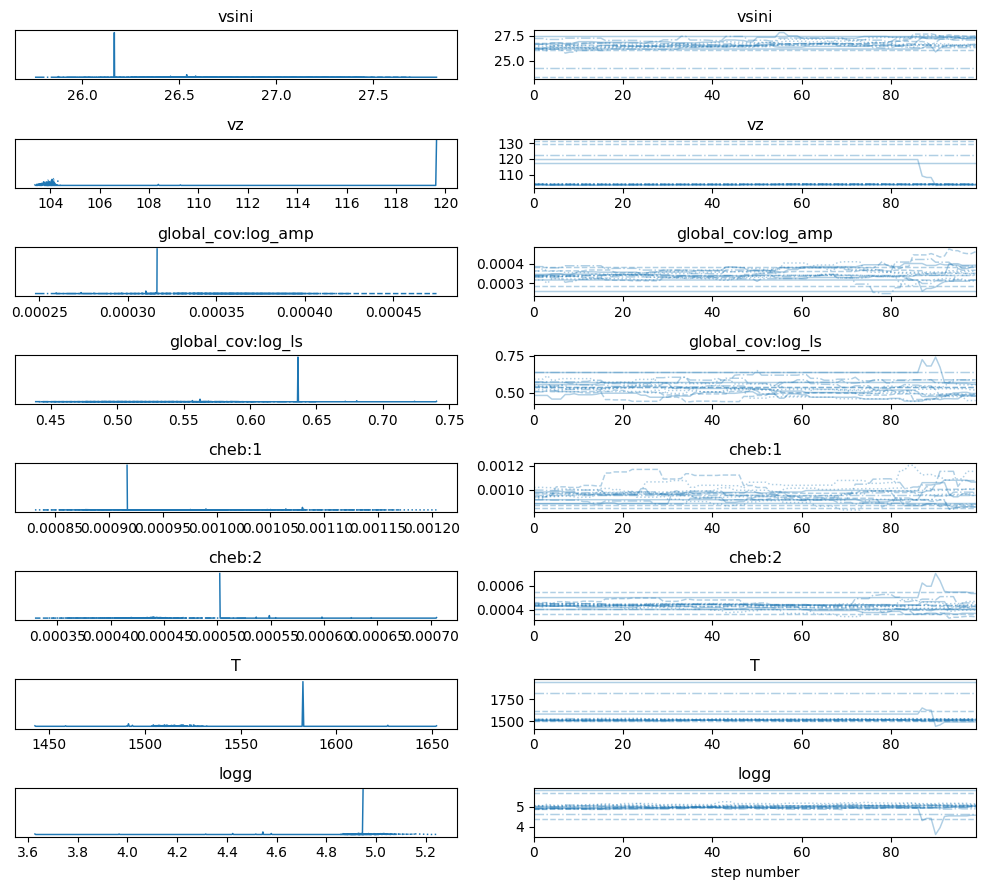

In [28]:
az.plot_trace(burn_data, figsize=(10,9));
plt.xlabel("step number")
plt.tight_layout()

In [29]:
az.summary(burn_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
vsini,26.314,1.049,23.323,27.485,0.249,0.179,20.0,17.0,3.06
vz,110.125,9.817,103.643,131.502,2.337,1.682,20.0,52.0,2.73
global_cov:log_amp,0.000,0.000,0.000,0.000,0.000,0.000,20.0,18.0,2.67
global_cov:log_ls,0.542,0.052,0.462,0.641,0.012,0.008,20.0,46.0,2.81
cheb:1,0.001,0.000,0.001,0.001,0.000,0.000,22.0,19.0,2.24
cheb:2,0.000,0.000,0.000,0.001,0.000,0.000,20.0,21.0,2.79
T,1571.103,125.053,1502.895,1953.717,29.921,21.531,20.0,19.0,2.68
logg,5.028,0.330,4.392,5.831,0.078,0.056,19.0,18.0,3.34


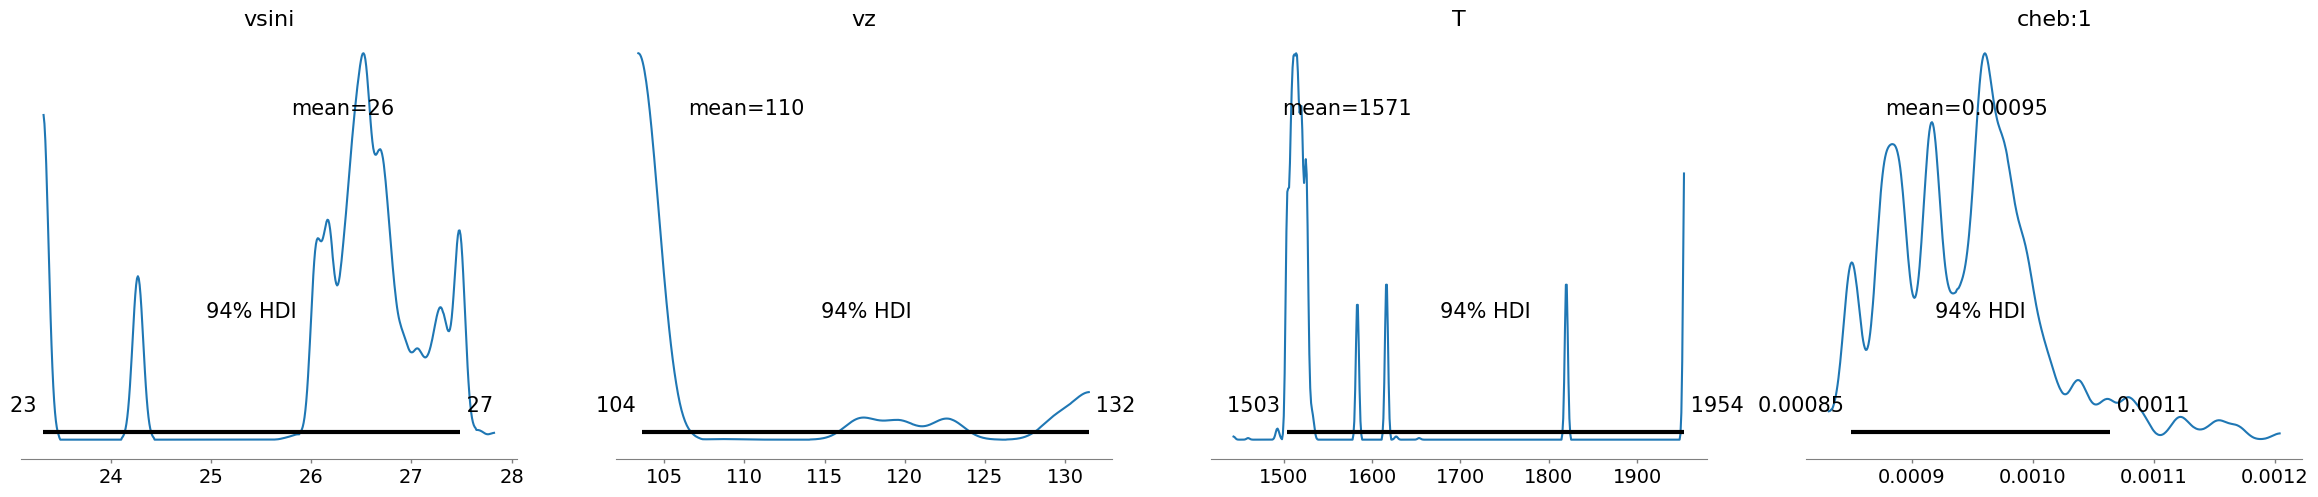

In [30]:
az.plot_posterior(burn_data, ["vsini", "vz", "T", "cheb:1"]);

In [39]:
burn_samples.reshape((-1, 4))

array([[ 2.73672866e+01,  1.03633578e+02,  1.05050112e+00,
        -1.19112539e+00],
       [ 1.49997650e+03,  2.63065011e+01,  1.03793509e+02,
         4.01066963e-01],
       [-6.23069890e-01,  1.50343222e+03,  2.64843677e+01,
         1.03997454e+02],
       ...,
       [-1.89355742e-01,  1.51132937e+03,  2.74360210e+01,
         1.03566526e+02],
       [ 1.72421266e-01, -3.07324803e-01,  1.50754606e+03,
         2.70306766e+01],
       [ 1.04288269e+02,  4.54090649e-02, -1.94292476e-01,
         1.50679087e+03]])

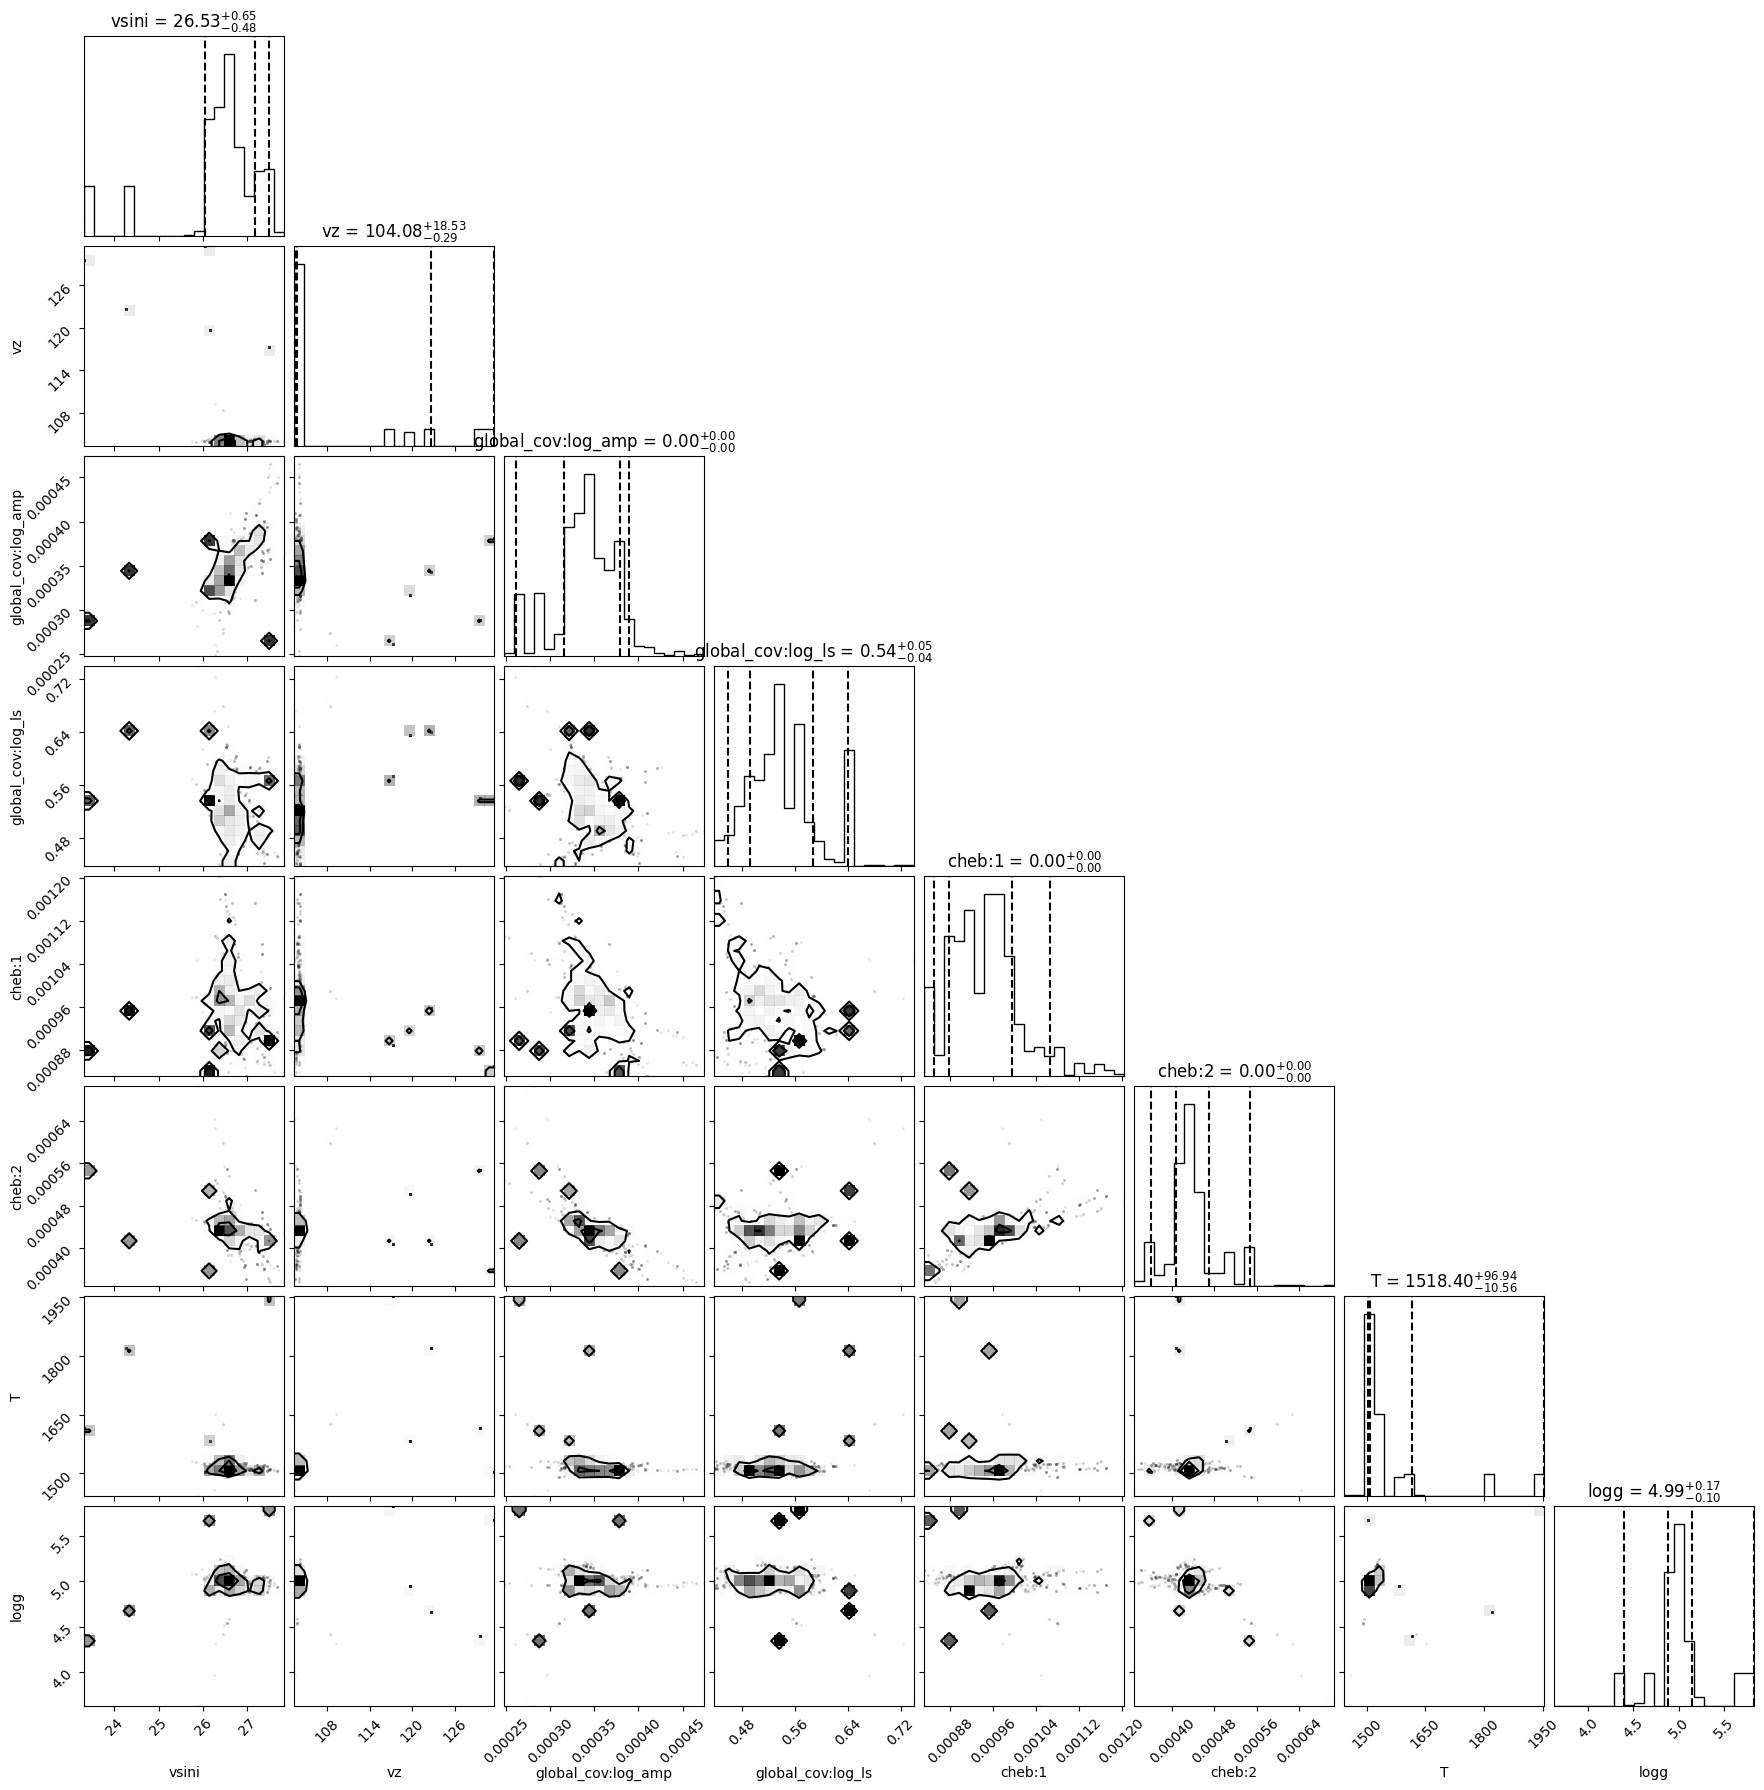

In [31]:
# See https://corner.readthedocs.io/en/latest/pages/sigmas.html#a-note-about-sigmas
#all_samples = reader.get_chain()
sigmas = ((1 - np.exp(-0.5)), (1 - np.exp(-2)))
corner.corner(
    burn_samples.reshape((-1, 8)),
    labels=model.labels,
    quantiles=(0.05, 0.16, 0.84, 0.95),
    levels=sigmas,
    show_titles=True
);

After looking at our posteriors, let's look at our fit

In [32]:
best_fit = dict(az.summary(burn_data)["mean"])
model.set_param_dict(best_fit)
model

SpectrumModel
-------------
Data: Spectrum
Emulator: BTSettl_K_emu
Log Likelihood: -1826.6366235953517

Parameters
  vsini: 26.314
  vz: 110.125
  global_cov:
    log_amp: 0.0
    log_ls: 0.542
  cheb: [0.001, 0.0]
  T: 1571.103
  logg: 5.028
  log_scale: 3.8718987760161245 (fit)

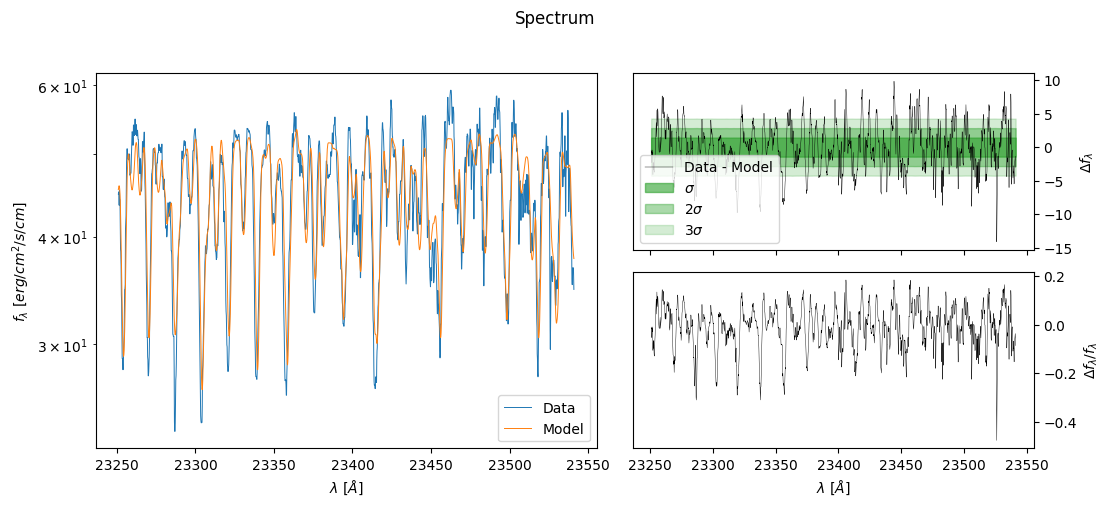

In [33]:
model.plot();

and finally, we can save our best fit.

In [50]:
model.save("example_sampled_1.toml")

Now, on to the next star!